# Text Analysis for Fake News Detection

This notebook implements text analysis techniques to process and classify news articles. Key components include text preprocessing, feature extraction, and model training.

## Data Import and Setup
Import required libraries and load training data containing news articles and comments.

In [8]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from collections import Counter
from itertools import chain
from math import log
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_file_path = r'C:\Users\Dell\OneDrive\Desktop\MLproj\endsem_eval\final_multimodal_train.tsv'
comments_file_path = r'C:\Users\Dell\OneDrive\Desktop\MLproj\endsem_eval\final_all_comments.tsv'

# Load TSV files
train_data = pd.read_csv(train_file_path, sep='\t', on_bad_lines='skip')
comments_data = pd.read_csv(comments_file_path, sep='\t', on_bad_lines='skip')

# Handle missing values in text columns
train_data['clean_title'] = train_data['clean_title'].fillna("")
comments_data['body'] = comments_data['body'].fillna("")

## Text Data Preprocessing
Combine article titles with comments and clean the text by:
1. Filling missing values
2. Creating dictionary for fast comment lookup
3. Merging titles with corresponding comments
4. Handling special cases like empty comments

In [ ]:
# Load datasets and inspect columns
train_data = pd.read_csv(train_file_path, sep='\t', on_bad_lines='skip')
comments_data = pd.read_csv(comments_file_path, sep='\t', on_bad_lines='skip')

# Debug: Check column names
print("Columns in train_data:", train_data.columns)
print("Columns in comments_data:", comments_data.columns)

# Rename columns if necessary
train_data = train_data.rename(columns=lambda x: x.strip())
comments_data = comments_data.rename(columns=lambda x: x.strip())

# Validate the existence of `id` and `submission_id`
if 'id' not in train_data.columns:
    raise KeyError("The column 'id' is not found in train_data.")
if 'submission_id' not in comments_data.columns:
    raise KeyError("The column 'submission_id' is not found in comments_data.")

# Ensure consistent column types
train_data['id'] = train_data['id'].astype(str).str.strip().str.lower()
comments_data['submission_id'] = comments_data['submission_id'].astype(str).str.strip().str.lower()

# Build `comments_dict` for fast lookup
comments_dict = {}
for _, row in comments_data.iterrows():
    submission_id = row['submission_id']
    body = str(row['body']).strip() if not pd.isnull(row['body']) else ""
    if submission_id in comments_dict:
        comments_dict[submission_id] += f" {body}"
    else:
        comments_dict[submission_id] = body

# Prepare final dataset
final_combined_data = []

# Step 1: Process rows from train_data
for _, row in train_data.iterrows():
    train_id = row['id']
    clean_title = str(row['clean_title']).strip() if not pd.isnull(row['clean_title']) else ""
    if train_id in comments_dict:
        # Combine `clean_title` with matching `body`
        body = comments_dict[train_id]
        combined_text = f"{clean_title} {body}".strip()
    else:
        # No match: use `clean_title` as is
        body = ""
        combined_text = clean_title
    final_combined_data.append({
        'id': train_id,
        'clean_title': clean_title,
        'body': body,
        'combined_text': combined_text
    })

# Step 2: Add unmatched rows from comments_data
unmatched_submission_ids = set(comments_data['submission_id']) - set(train_data['id'])
for submission_id in unmatched_submission_ids:
    body = comments_dict[submission_id]
    final_combined_data.append({
        'id': submission_id,
        'clean_title': "",
        'body': body,
        'combined_text': body.strip()
    })

# Convert to DataFrame
final_combined_data_df = pd.DataFrame(final_combined_data)
 
output_path = 'final_combined_data_fixed.csv'
final_combined_data_df.to_csv(output_path, index=False)

# Debugging: Check row count and a sample of the data
print(f"Number of rows in final dataset: {len(final_combined_data_df)}")
# print(final_combined_data_df.head())
final_combined_data_df


Columns in train_data: Index(['author', 'clean_title', 'created_utc', 'domain', 'id', 'num_comments',
       'score', 'subreddit', 'title', 'upvote_ratio', '2_way_label', 'year',
       'month', 'day'],
      dtype='object')
Columns in comments_data: Index(['id', 'author', 'body', 'submission_id', 'ups'], dtype='object')
Number of rows in final dataset: 60000


,id,clean_title,body,combined_text
0,c7773wn,feeling lucky,,feeling lucky
1,cgs3w93,cutouts,,cutouts
2,cmk4af,my ceiling looks like an sd card,Your sd card looks like a ceiling It looks lik...,my ceiling looks like an sd card Your sd card ...
3,k3n1m,join the raaf,,join the raaf
4,cplcw5p,hangover,,hangover
...,...,...,...,...
59995,dk5zml,a roll thats pretty funny on my grandparents car,Wait until 69420 Nice So wait... What would a ...,a roll thats pretty funny on my grandparents c...
59996,b3kkih,old railway wagon turned storage shed,,old railway wagon turned storage shed
59997,6vntk0,sisyphus moss covered stones,Thank you for submitting your post to /r/fakea...,sisyphus moss covered stones Thank you for sub...
59998,5a48al,rare photo of jesus c ad,Forwards To Grandma His midiclorian count was ...,rare photo of jesus c ad Forwards To Grandma H...


## Model Training Setup
1. Load processed data with labels
2. Preprocess text:
   - Remove URLs
   - Remove punctuation
   - Convert to lowercase
3. Create TF-IDF features
4. Split data into train/test sets

In [10]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from scipy.stats import loguniform
import pandas as pd
import numpy as np
import time
import regex as re

# File paths
combined_data_path = r"final_combined_data_fixed.csv"
label_data_path = r"C:\Users\Dell\OneDrive\Desktop\MLproj\endsem_eval\final_multimodal_train.tsv"

# Load the datasets
final_combined_data = pd.read_csv(combined_data_path)
label_data = pd.read_csv(label_data_path, sep="\t")

# Ensure the `id` column is consistent in both datasets
final_combined_data['id'] = final_combined_data['id'].astype(str).str.strip()
label_data['id'] = label_data['id'].astype(str).str.strip()

# Merge the `2_way_label` column from the label data
merged_data = final_combined_data.merge(
    label_data[['id', '2_way_label']],
    on='id',
    how='left'
)

# Check for missing labels
missing_labels = merged_data['2_way_label'].isna().sum()
print(f"Number of rows missing labels: {missing_labels}")

# Save the updated dataset
output_path = "final_combined_data_with_labels.csv"
merged_data.to_csv(output_path, index=False)


# Preprocessing
def preprocess_text(text):
    text = str(text)
    text = re.sub(r"http\S+", " ", text)  # Replace URLs
    text = re.sub(r"[^\w\s]", " ", text)  # Remove punctuation
    text = text.lower().strip()  # Lowercase and trim
    return text

merged_data['processed_text'] = merged_data['combined_text'].fillna("").apply(preprocess_text)

# Reduce Dataset Size (optional)
merged_data = merged_data.sample(n=10000, random_state=42)

# TF-IDF Vectorization with fewer features
tfidf_vectorizer = TfidfVectorizer(max_features=3000, stop_words="english")  # Reduce max features
X_tfidf = tfidf_vectorizer.fit_transform(merged_data['processed_text'])  # Keep sparse format
# Use the `2_way_label` column as your labels
y = merged_data['2_way_label']
 
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, stratify=y, random_state=42)
# print(y)

Number of rows missing labels: 0


## Model Configuration
Define hyperparameter search spaces for multiple models:
- Logistic Regression
- Random Forest
- SVM
- Decision Tree

Each model has specific parameters tuned for text classification tasks.

In [11]:
# Hyperparameter spaces
param_dist_lr = {
    'C': loguniform(1e-4, 1e2),
    'solver': ['liblinear', 'saga']
}

param_dist_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Refined hyperparameter spaces
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300,500],
    'max_depth': [None, 1,10, 20, 50, 100,300,500],
    'min_samples_split': [2, 5, 10],  # Avoid invalid values
    'min_samples_leaf': [1, 2, 5,10],
    'class_weight': ['balanced', None]
}

param_dist_svm = {
    'C': loguniform(1e-4, 1e2),
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'degree': [2, 3, 4],  # Only for `poly` kernel
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced', None]
}

# Models dictionary remains unchanged
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), param_dist_lr),
    'Random Forest': (RandomForestClassifier(), param_dist_rf),
    'SVM': (SVC(probability=True), param_dist_svm),
    'Decision Tree': (DecisionTreeClassifier(), param_dist_dt)
} 

## Model Training and Evaluation
Train multiple models using RandomizedSearchCV:
1. Iterate through models
2. Perform cross-validation
3. Track performance metrics:
   - Accuracy
   - ROC-AUC
   - Log Loss
4. Save best parameters and results

In [12]:
# Train and evaluate models
results = []
for model_name, (model, param_dist) in models.items():
    print(f"\nHyperparameter Tuning for {model_name}...")
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=30,  # Increased iterations for better exploration
        cv=3,
        scoring='accuracy',
        verbose=2,
        random_state=42,
        n_jobs=-1  # Use all processors
    )
    
    start_time = time.time()
    random_search.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    logloss = log_loss(y_test, y_prob) if y_prob is not None else "N/A"
    best_params = random_search.best_params_
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {roc_auc}")
    print(f"Log Loss: {logloss}")
    print(f"Best Parameters: {best_params}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'ROC-AUC': roc_auc,
        'Log Loss': logloss,
        'Best Params': best_params,
        'Elapsed Time (s)': elapsed_time
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False)
results_df.reset_index(drop=True, inplace=True)

results_df

output_results_path = "model_hyperparameter_results_30iter_3000features.csv"
results_df.to_csv(output_results_path, index=False)
print(f"Results saved to {output_results_path}")



Hyperparameter Tuning for Logistic Regression...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Logistic Regression Results:
Accuracy: 0.7927
ROC-AUC: 0.8752690728263313
Log Loss: 0.4274951125579102
Best Parameters: {'C': np.float64(1.7718847354806828), 'solver': 'saga'}
Elapsed Time: 8.31 seconds

Hyperparameter Tuning for Random Forest...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Random Forest Results:
Accuracy: 0.8070
ROC-AUC: 0.8896062871974137
Log Loss: 0.4056195198042078
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 500, 'class_weight': None}
Elapsed Time: 187.28 seconds

Hyperparameter Tuning for SVM...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

SVM Results:
Accuracy: 0.8050
ROC-AUC: 0.8689041368013468
Log Loss: 0.44462484975952826
Best Parameters: {'C': np.float64(0.39079671568228835), 'class_weight': 'balanced', 'degree': 3, 'gamma': 'scale', 'kernel': 'sigmoid'}
Elapsed

## Model Performance Visualization
Create visualization for model evaluation:
1. Confusion matrix showing true vs predicted labels
2. Calculate detailed performance metrics
3. Generate classification report

In [13]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Load the datasets
final_combined_data = pd.read_csv("final_combined_data_with_labels.csv")
final_multimodal_train = pd.read_csv(r'C:\Users\Dell\OneDrive\Desktop\MLproj\endsem_eval\final_multimodal_train.tsv', sep='\t')  # Use sep='\t' for TSV files


# Step 2: Text Preprocessing
def preprocess_text(text):
    text = str(text)
    text = re.sub(r"http\S+", " ", text)  # Replace URLs
    text = re.sub(r"[^\w\s]", " ", text)  # Remove punctuation
    text = text.lower().strip()  # Lowercase and trim
    return text

# Preprocess the combined_text column
final_combined_data['processed_text'] = final_combined_data['combined_text'].fillna("").apply(preprocess_text)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=3000, stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(final_combined_data['processed_text'])

# Step 3: Train-Test Split
# Use the `2_way_label` column as labels
y = final_combined_data['2_way_label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.3, stratify=y, random_state=42
)

# Step 4: Train Random Forest Classifier
best_rf = RandomForestClassifier(
    n_estimators=300, 
    min_samples_split=5, 
    min_samples_leaf=2, 
    max_depth=500, 
    class_weight=None,
    random_state=42
)
best_rf.fit(X_train, y_train)

# Step 5: Evaluate the Model
# Predict on the test set
y_pred = best_rf.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print Accuracy
print(f"Random Forest Test Accuracy: {accuracy:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86     10930
           1       0.80      0.78      0.79      7070

    accuracy                           0.83     18000
   macro avg       0.83      0.83      0.83     18000
weighted avg       0.83      0.83      0.83     18000

Random Forest Test Accuracy: 0.8348


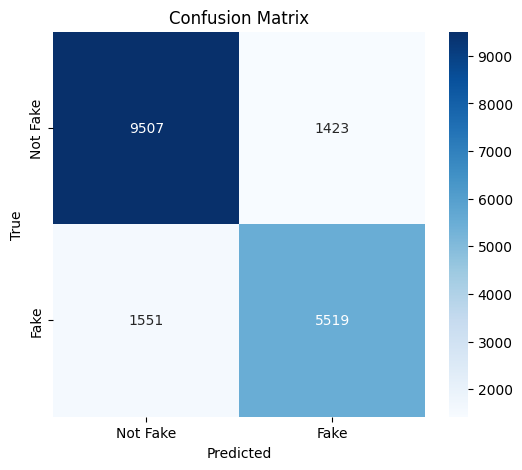

In [14]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fake", "Fake"], yticklabels=["Not Fake", "Fake"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Generate Predictions
Use the best model to:
1. Generate probability predictions for all articles
2. Merge predictions with original dataset
3. Save updated dataset with probability scores

These probabilities will be used as features in the ensemble model.

In [15]:

# Step 6: Predict Probabilities for Combined Text
combined_text_probabilities = best_rf.predict_proba(X_tfidf)[:, 1]  # Probability for "fake" class

# Append probabilities to the dataset
final_combined_data['tfidf_probability'] = combined_text_probabilities

# Step 7: Merge with Original Dataset
# Ensure IDs are consistent
final_multimodal_train['id'] = final_multimodal_train['id'].astype(str).str.strip().str.lower()
final_combined_data['id'] = final_combined_data['id'].astype(str).str.strip().str.lower()

# Merge on ID and keep all original columns + combined_text and tfidf_probability
updated_multimodal_train = final_multimodal_train.merge(
    final_combined_data[['id', 'tfidf_probability']],
    on='id',
    how='left'
)

# Step 8: Save the Updated Dataset
updated_multimodal_train.to_csv("final_multimodal_train_with_probabilities_3k.csv", index=False)

print("Updated dataset saved to 'final_multimodal_train_with_probabilities_3k.csv'.")


Updated dataset saved to 'final_multimodal_train_with_probabilities_3k.csv'.


In [ ]:
final_combined_data[['combined_text', 'tfidf_probability']]

,combined_text,tfidf_probability
0,feeling lucky,0.067640
1,cutouts,0.000074
2,my ceiling looks like an sd card Your sd card ...,0.330587
3,join the raaf,0.034882
4,hangover,0.029600
...,...,...
59995,a roll thats pretty funny on my grandparents c...,0.664315
59996,old railway wagon turned storage shed,0.435465
59997,sisyphus moss covered stones Thank you for sub...,0.039833
59998,rare photo of jesus c ad Forwards To Grandma H...,0.055019
